<font size="+2" color="blue">Additional results: surprise library</font>

# Practice PS06: Recommendations engines (interactions-based)

For this assignment we will build and apply an item-based and model-based collaborative filtering recommenders for movies.

# 1. The Movies dataset

# 1.1. Load the input files

In [ ]:
# Leave this code as-is

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import*
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags-2000s.csv"

In [ ]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES,
                    sep=',',
                    engine='python',
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS,
                    sep=',',
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


# 1.2. Merge the data into a single dataframe

<font size="+1" color="red">Replace this cell with your code from the previous practice that joined these three dataframes using "merge" into a single dataframe named "ratings". Print the first 5 rows of the resulting dataframe, which should contain columns "user_id", "movie_id", "rating", "title", and "genres".</font>

In [ ]:
ratings = pd.merge(ratings_raw, movies, how='inner', on='movie_id')
ratings.head()

,user_id,movie_id,rating,title,genres
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western
1,4,3751,3.5,Chicken Run (2000),Animation|Children|Comedy
2,4,3793,1.5,X-Men (2000),Action|Adventure|Sci-Fi
3,4,3827,3.0,Space Cowboys (2000),Action|Adventure|Comedy|Sci-Fi
4,4,4308,3.5,Moulin Rouge (2001),Drama|Musical|Romance


<font size="+1" color="red">Replace this cell with your code from the previous practice for "find_movies" that list movies containing a keyword</font>

In [ ]:
def find_movies(keyword, movies_df):
    # Convert keyword to lowercase for case-insensitive search
    keyword = keyword.lower()

    # Filter movies whose title contains the keyword
    matching_movies = movies_df[movies_df['title'].str.lower().str.contains(keyword)]

    # Print results
    for index, row in matching_movies.iterrows():
        print(f"movie_id: {row['movie_id']}, title: {row['title']}")

In [ ]:
# LEAVE AS-IS

# For testing, this should print 9 movies
find_movies("Spider-Man", movies)

movie_id: 5349, title: Spider-Man (2002)
movie_id: 8636, title: Spider-Man 2 (2004)
movie_id: 52722, title: Spider-Man 3 (2007)
movie_id: 76709, title: Spider-Man: The Ultimate Villain Showdown (2002)
movie_id: 95510, title: Amazing Spider-Man, The (2012)
movie_id: 110553, title: The Amazing Spider-Man 2 (2014)
movie_id: 122926, title: Untitled Spider-Man Reboot (2017)
movie_id: 195159, title: Spider-Man: Into the Spider-Verse (2018)
movie_id: 201773, title: Spider-Man: Far from Home (2019)


In [ ]:
# LEAVE AS-IS

def get_title(movie_id, movies):
    return movies[movies['movie_id'] == movie_id].title.iloc[0]

In [ ]:
# LEAVE AS-IS

# For testing, should print "Spider-Man 2 (2004)"
print(get_title(8636, movies))

Spider-Man 2 (2004)


## 1.3. Count unique registers

<font size="+1" color="red">Replace this cell with your own code to indicate the number of unique users and unique movies in the "ratings" variable.</font>

In [ ]:
# Print the results
print(f"Number of users who have rated a movie : {len(ratings['user_id'].unique())}")
print(f"Number of movies that have been rated  : {len(ratings['movie_id'].unique())}")
print(f"Total number of movies                 : {movies.shape[0]}")

Number of users who have rated a movie : 12676
Number of movies that have been rated  : 2049
Total number of movies                 : 33168


# 2. Item-based Collaborative Filtering

## 2.1. Data pre-processing

<font size="+1" color="red">Replace this cell with your code to generate "rated_movies" and print the first ten rows. This should have columns user_id, movie_id, rating, title</font>

In [ ]:
rated_movies = ratings.drop(columns=['genres'])
rated_movies.head(10)

,user_id,movie_id,rating,title
0,4,3624,2.5,Shanghai Noon (2000)
1,4,3751,3.5,Chicken Run (2000)
2,4,3793,1.5,X-Men (2000)
3,4,3827,3.0,Space Cowboys (2000)
4,4,4308,3.5,Moulin Rouge (2001)
5,4,4816,4.0,Zoolander (2001)
6,4,4886,3.5,"Monsters, Inc. (2001)"
7,4,4963,4.5,Ocean's Eleven (2001)
8,4,4974,4.0,Not Another Teen Movie (2001)
9,4,4993,4.5,"Lord of the Rings: The Fellowship of the Ring,..."


<font size="+1" color="red">Replace this cell with your code to generate "ratings_summary" and print the first 10 rows.</font>

In [ ]:
# Step 1: Initialize ratings_summary with movie_id and title
ratings_summary = rated_movies[['movie_id', 'title']].drop_duplicates()

# Step 2: Compute ratings_mean and ratings_count
ratings_summary = ratings_summary.groupby('movie_id').first()
ratings_mean = rated_movies.groupby('movie_id')['rating'].mean()
ratings_count = rated_movies.groupby('movie_id')['rating'].count()

# Step 3: Add these series to ratings_summary
ratings_summary['ratings_mean']=ratings_mean
ratings_summary['ratings_count']=ratings_count

# Reset the index to ensure movie_id is a column
ratings_summary.reset_index(inplace=True)
ratings_summary.head(10)

,movie_id,title,ratings_mean,ratings_count
0,2769,"Yards, The (2000)",3.122549,102
1,3177,Next Friday (2000),2.824000,125
2,3190,Supernova (2000),2.395683,139
3,3225,Down to You (2000),2.577273,110
4,3228,Wirey Spindell (2000),2.500000,2
5,3239,Isn't She Great? (2000),1.947368,19
6,3273,Scream 3 (2000),2.444664,759
7,3275,"Boondock Saints, The (2000)",3.870682,1071
8,3276,Gun Shy (2000),3.338710,31
9,3279,Knockout (2000),2.000000,2


In [ ]:
# Step 1: Initialize ratings_summary with movie_id and title
ratings_summary = rated_movies[['movie_id', 'title']].drop_duplicates()

# Step 2: Compute ratings_mean and ratings_count
ratings_summary = ratings_summary.groupby('movie_id').first()
ratings_mean = rated_movies.groupby('movie_id')['rating'].mean()
ratings_count = rated_movies.groupby('movie_id')['rating'].count()

# Step 3: Add these series to ratings_summary
ratings_summary = ratings_summary.join(ratings_mean.rename('ratings_mean'), on='movie_id')
ratings_summary = ratings_summary.join(ratings_count.rename('ratings_count'), on='movie_id')

# Reset the index to ensure movie_id is a column
ratings_summary.reset_index(inplace=True)
ratings_summary.head(10)

,movie_id,title,ratings_mean,ratings_count
0,2769,"Yards, The (2000)",3.122549,102
1,3177,Next Friday (2000),2.824000,125
2,3190,Supernova (2000),2.395683,139
3,3225,Down to You (2000),2.577273,110
4,3228,Wirey Spindell (2000),2.500000,2
5,3239,Isn't She Great? (2000),1.947368,19
6,3273,Scream 3 (2000),2.444664,759
7,3275,"Boondock Saints, The (2000)",3.870682,1071
8,3276,Gun Shy (2000),3.338710,31
9,3279,Knockout (2000),2.000000,2


<font size="+1" color="red">Replace this cell with code to print the top 5 highest rated movies, considering only movies receiving at least 100 ratings.</font>

In [ ]:
top_rated_movies_100 = ratings_summary[ratings_summary['ratings_count'] >= 100]
top_rated_movies_sorted_100 = top_rated_movies_100.sort_values(by='ratings_mean', ascending=False)
top_rated_movies_sorted_100.head()

,movie_id,title,ratings_mean,ratings_count
740,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.215216,2458
881,6016,City of God (Cidade de Deus) (2002),4.186592,2133
259,4226,Memento (2000),4.158512,4476
1250,7156,Fog of War: Eleven Lessons from the Life of Ro...,4.112013,308
488,4973,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",4.097234,3687


<font size="+1" color="red">Repeat this, but this time consider movies receiving at least 3 ratings.</font>

In [ ]:
top_rated_movies_3 = ratings_summary[ratings_summary['ratings_count'] >= 3]
top_rated_movies_sorted_3 = top_rated_movies_3.sort_values(by='ratings_mean', ascending=False)
top_rated_movies_sorted_3.head()

,movie_id,title,ratings_mean,ratings_count
534,5082,"Rumor of Angels, A (2000)",4.666667,6
1778,27764,2LDK (2003),4.500000,3
1961,31954,Beautiful City (Shah-re ziba) (2004),4.400000,5
572,5224,Promises (2001),4.388889,18
1149,6775,Life and Debt (2001),4.333333,3


<font size="+1" color="red">Replace this cell with a brief commentary, in your own words, on what happens when the number of ratings is set to a small value.</font>

When the number of ratings is small, the mean rating is not as precise as a large number of ratings. The means are so close to 2 format decimal or have periodic numbers (e.g., 4.666667, 4.500000).

If the number of ratings is large, we can see more precise decimals (e.g., 4.215216).

## 2.2. Compute the user-movie matrix

<font size="+1" color="red">Replace this cell with code to generate a "user_movie" matrix by calling "pivot_table" on "rated_movies". Print the first 5 rows. It might take about one minute to compute, depending on your computer.</font>

In [ ]:
user_movie = rated_movies.pivot_table(index='user_id', columns='movie_id', values='rating')
user_movie.head()

movie_id,2769,3177,3190,3225,3228,3239,3273,3275,3276,3279,...,33138,33145,33148,33150,33152,33154,33158,33162,33164,33166
user_id,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font size="+1" color="red">Replace this a brief commentary indicating why do you think the "user_movie" matrix has so many "NaN" values. How do we call this characteristic of user ratings in recommender systems?</font>

The user_movie matrix has many NaN values because, in most cases, each user rates only a small subset of all available movies. This means that there are numerous movies each user has not rated, leading to empty cells in the matrix.

In recommender systems, this characteristic is known as sparsity. Sparsity is common in user-item matrices because the number of items (e.g., movies, books) is usually large, while each user typically interacts with only a fraction of them. This sparsity presents challenges for algorithms that rely on user ratings, as it can be difficult to draw meaningful patterns or similarities from such incomplete data.

# 2.3. Explore some correlations in the user-movie matrix

<font size="+1" color="red">Replace this cell with code to compute and display the first 10 rows of the "ratings3" table as described above.</font>

In [ ]:
# Define the movie IDs for each of the specified movies
id_pivot = int(movies[movies['title'] == 'Lord of the Rings: The Fellowship of the Ring, The (2001)']['movie_id'].iloc[0])
id_m1 = int(movies[movies['title'] == 'Finding Nemo (2003)']['movie_id'].iloc[0])
id_m2 = int(movies[movies['title'] == 'Talk to Her (Hable con Ella) (2002)']['movie_id'].iloc[0])

# Obtain the ratings series for each movie, dropping NaN values
s1 = user_movie[id_pivot].dropna()
s2 = user_movie[id_m1].dropna()
s3 = user_movie[id_m2].dropna()

# Consolidate these series into a single DataFrame
ratings3 = pd.concat([s1, s2, s3], axis=1)
# Drop rows containing any NaN values to keep users who rated all three movies
ratings3.dropna(inplace=True)
ratings3.head(10)

,4993,6377,5878
user_id,,,
859,3.0,4.0,5.0
1229,4.0,4.0,4.5
1281,3.0,2.5,3.0
1722,5.0,4.5,4.0
2004,4.5,3.0,3.5
4590,4.0,4.0,2.0
5052,2.0,4.0,4.0
5144,5.0,5.0,5.0
6497,3.5,3.5,3.5


<font size="+1" color="red">Replace this cell with code to compute all correlations between these three movies, as described above.</font>

In [ ]:
correlation_1= ratings3[id_pivot].corr(ratings3[id_m1])
correlation_2= ratings3[id_pivot].corr(ratings3[id_m2])
correlation_3= ratings3[id_m1].corr(ratings3[id_m2])

In [ ]:
print("Similarity between 'Lord of the Rings: The Fellowship of the Ring, The (2001)' and 'Finding Nemo (2003):", correlation_1)
print("Similarity between 'Lord of the Rings: The Fellowship of the Ring, The (2001)' and 'Talk to Her (Hable con Ella) (2002)", correlation_2)
print("Similarity between 'Finding Nemo (2003)' and 'Talk to Her (Hable con Ella) (2002)':", correlation_3)

Similarity between 'Lord of the Rings: The Fellowship of the Ring, The (2001)' and 'Finding Nemo (2003): 0.3840549071566764
Similarity between 'Lord of the Rings: The Fellowship of the Ring, The (2001)' and 'Talk to Her (Hable con Ella) (2002) 0.16240502267155424
Similarity between 'Finding Nemo (2003)' and 'Talk to Her (Hable con Ella) (2002)': 0.2042645045941218


<font size="+1" color="red">Replace this cell with a brief commentary on the correlations you find.</font>

The computed correlations among the three movies reveal interesting insights into how users rated these films:

**Correlation between 'Lord of the Rings' and 'Finding Nemo' (0.38):**

This moderate positive correlation suggests that users who rated "Lord of the Rings: The Fellowship of the Ring" highly also tended to rate "Finding Nemo" favorably. The plot is not similar between the films, but the "fantasy" aspect can be related.

**Correlation between 'Lord of the Rings' and 'Talk to Her' (0.16):**

The low correlation between "Lord of the Rings" and "Talk to Her" suggests that ratings for these two films are relatively independent of each other. This could be attributed to the significant differences in genre, tone, and audience appeal.

**Correlation between 'Finding Nemo' and 'Talk to Her' (0.20):**

The correlation between "Finding Nemo" and "Talk to Her" is also low, is slightly higher than the previous correlation. This indicates a weak positive relationship, suggesting that while there may be some overlap in viewers who enjoy both animated family films and more nuanced dramas, the connection is not strong. Audiences for these films likely have differing preferences based on the contrasting styles and themes of the movies.

<font size="+1" color="red">Replace this cell with code to create a "similarity_to_pivot" series that contains the computed correlations, droping the NaNs in the series.</font>

In [ ]:
ratings_pivot = pd.DataFrame(user_movie[id_pivot].dropna()).rename(columns={id_pivot: "rating"})
similarity_to_pivot = user_movie.corrwith(ratings_pivot['rating'])
similarity_to_pivot = similarity_to_pivot.reset_index().rename(columns={'index': 'movie_id', 0: 'corr_with_pivot'})
similarity_to_pivot

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/

,movie_id,corr_with_pivot
0,2769,-0.127515
1,3177,0.093221
2,3190,0.041206
3,3225,0.126600
4,3228,NaN
...,...,...
2044,33154,0.318255
2045,33158,0.228214
2046,33162,0.285377
2047,33164,0.037130


<font size="+1" color="red">Replace this cell with code to create a "corr_with_pivot" dataframe as specified above, and to print the 20 movies (rated 500 times or more) with the highest correlation with the selected movie.</font>

In [ ]:
# Join similarity_pivot with ratings_summary using 'movie_id' such as the column key
corr_with_pivot = similarity_to_pivot.merge(ratings_summary, how='inner', on='movie_id')

# Filter the films with at least 500 ratings
corr_with_pivot = corr_with_pivot[corr_with_pivot['ratings_count'] >= 500]

# Sort and show the first 20 highest corr movies
top_movies = corr_with_pivot.sort_values('corr_with_pivot', ascending=False).head(20)
top_movies

,movie_id,corr_with_pivot,title,ratings_mean,ratings_count
499,4993,1.000000,"Lord of the Rings: The Fellowship of the Ring,...",4.092530,5944
849,5952,0.892103,"Lord of the Rings: The Two Towers, The (2002)",4.083869,5449
1247,7153,0.892073,"Lord of the Rings: The Return of the King, The...",4.083960,5449
1036,6539,0.377599,Pirates of the Caribbean: The Curse of the Bla...,3.779241,3950
1421,8368,0.340934,Harry Potter and the Prisoner of Azkaban (2004),3.809971,2397
60,3578,0.337667,Gladiator (2000),3.951050,4811
92,3793,0.329686,X-Men (2000),3.556436,3535
469,4896,0.319180,Harry Potter and the Sorcerer's Stone (a.k.a. ...,3.678509,2843
73,3624,0.307471,Shanghai Noon (2000),3.297443,1017
1932,31658,0.303898,Howl's Moving Castle (Hauru no ugoku shiro) (2...,4.064417,1141


<font size="+1" color="red">Replace this cell with a brief commentary about the movies you see on this list. What happens if you set the condition on *ratings_count* to a much larger value? What happens if you set it to a much smaller value?</font>

When the ratings_count is much larger, the ratings_mean increases. Most of them are over 4 score.
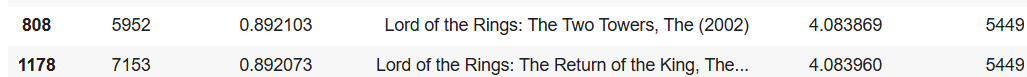

The ratings_count lower are more probably to get a ratings_mean lower.
It could be because when a film is famous, it tends to get a positive feedback. Meanwhile, films with fewer ratings, we assume they were not gotten famous and the small audience not keep interest to them.
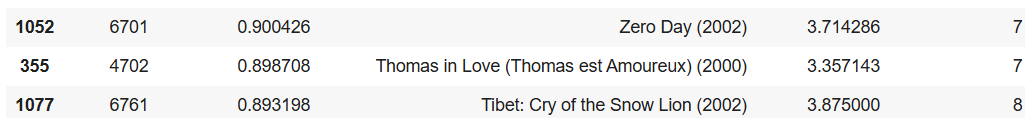

# 2.4. Implement the item-based recommendations

<font size="+1" color="red">Replace this cell with your code to compute all correlations between columns (movies) in the matrix user_movie. Store this in "item_similarity", and print the first 10 rows.</font>

In [ ]:
item_similarity = user_movie.corr()
item_similarity.head(10)

movie_id,2769,3177,3190,3225,3228,3239,3273,3275,3276,3279,...,33138,33145,33148,33150,33152,33154,33158,33162,33164,33166
movie_id,,,,,,,,,,,,,,,,,,,,,
2769,1.000000,0.115068,0.033721,-0.232268,NaN,-0.500000,0.197011,0.199514,0.250873,NaN,...,0.379980,0.878310,NaN,NaN,NaN,0.248126,1.806095e-01,-0.085570,-0.408248,0.105671
3177,0.115068,1.000000,0.303820,0.559533,NaN,NaN,0.331191,0.167918,1.000000,NaN,...,0.546119,0.735767,-1.0,NaN,NaN,-0.221382,3.174747e-01,0.014735,0.661989,0.185654
3190,0.033721,0.303820,1.000000,0.636361,NaN,-0.014315,0.146042,0.394293,-0.290397,NaN,...,0.246183,0.632026,NaN,NaN,NaN,0.378181,1.709261e-01,0.022444,-0.073360,-0.054114
3225,-0.232268,0.559533,0.636361,1.000000,NaN,0.578414,0.347716,0.263671,-0.250313,NaN,...,-0.300376,0.318377,NaN,NaN,NaN,0.480173,7.503063e-01,0.536828,0.753141,0.098748
3228,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3239,-0.500000,NaN,-0.014315,0.578414,NaN,1.000000,0.180846,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,0.636285,0.888200
3273,0.197011,0.331191,0.146042,0.347716,NaN,0.180846,1.000000,0.105735,0.154371,NaN,...,0.006774,0.409968,1.0,NaN,NaN,0.088405,7.516779e-02,0.143492,0.466705,0.084202
3275,0.199514,0.167918,0.394293,0.263671,NaN,1.000000,0.105735,1.000000,0.485071,NaN,...,-0.011426,0.279624,NaN,NaN,NaN,0.075827,2.994603e-01,0.187713,0.285584,0.225317
3276,0.250873,1.000000,-0.290397,-0.250313,NaN,NaN,0.154371,0.485071,1.000000,NaN,...,NaN,0.292770,NaN,NaN,NaN,0.000000,-6.885311e-17,-0.455530,0.500000,-0.138013


<font size="+1" color="red">Replace this cell with your code to compute all correlations between columns (movies) in the matrix user_movie, but considering only movies having at least 100 ratings in common. Store this in "item_similarity_min_ratings"</font>

In [ ]:
item_similarity_min_ratings = user_movie.corr(min_periods=100)

In [ ]:
item_similarity_min_ratings.head()

movie_id,2769,3177,3190,3225,3228,3239,3273,3275,3276,3279,...,33138,33145,33148,33150,33152,33154,33158,33162,33164,33166
movie_id,,,,,,,,,,,,,,,,,,,,,
2769,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3177,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3190,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3225,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font size="+1" color="red">Replace this cell with your code to find the userids of two example users: user_id_super (the who liked the three superhero movies), and user_id_drama (the one who liked the three dramas)</font>

In [ ]:
user_id_super_1 = rated_movies[
    ((rated_movies['movie_id'] == 5349) & (rated_movies['rating'] > 4.5))
]
user_id_super_2 = rated_movies[
    ((rated_movies['movie_id'] == 3793) & (rated_movies['rating'] > 4.5))
]
user_id_super_3 = rated_movies[
    ((rated_movies['movie_id'] == 6534) & (rated_movies['rating'] > 4.5))
]
user_id_df1=user_id_super_1.merge(user_id_super_2, how='inner', on='user_id')
user_id_super=user_id_df1.merge(user_id_super_3, how='inner', on='user_id')['user_id'][0]

user_id_drama_1 = rated_movies[
    ((rated_movies['movie_id'] == 6870) & (rated_movies['rating'] > 4.5))
]
user_id_drama_2 = rated_movies[
    ((rated_movies['movie_id'] == 5995) & (rated_movies['rating'] > 4.5))
]
user_id_drama_3 = rated_movies[
    ((rated_movies['movie_id'] == 3555) & (rated_movies['rating'] > 4.5))
]
user_id_df2=user_id_drama_1.merge(user_id_drama_2, how='inner', on='user_id')
user_id_drama=user_id_df2.merge(user_id_drama_3, how='inner', on='user_id')['user_id'][0]

In [ ]:
print("User ID for Super User (Superhero movies):", user_id_super)
print("User ID for Drama User (Drama movies):", user_id_drama)

User ID for Super User (Superhero movies): 127342
User ID for Drama User (Drama movies): 34336


In [ ]:
# Leave this code as-is

# Gets a list of watched movies for a user_id
def get_watched_movies(user_id, user_movie):
    return list(user_movie.loc[user_id].dropna().sort_values(ascending=False).index)

# Gets the rating a user_id has given to a movie_id
def get_rating(user_id, movie_id, user_movie):
    return user_movie[movie_id][user_id]

# Print watched movies
def print_watched_movies(user_id, user_movie, movies):
    for movie_id in get_watched_movies(user_id, user_movie):
        print("%d %.1f %s " %
          (movie_id, get_rating(user_id, movie_id, user_movie), get_title(movie_id, movies)))

In [ ]:
# LEAVE AS-IS (TESTING CODE)

print_watched_movies(user_id_super, user_movie, movies)

5502 5.0 Signs (2002) 
5445 5.0 Minority Report (2002) 
6156 5.0 Shanghai Knights (2003) 
5952 5.0 Lord of the Rings: The Two Towers, The (2002) 
5944 5.0 Star Trek: Nemesis (2002) 
5816 5.0 Harry Potter and the Chamber of Secrets (2002) 
5618 5.0 Spirited Away (Sen to Chihiro no kamikakushi) (2001) 
5524 5.0 Blue Crush (2002) 
5480 5.0 Stuart Little 2 (2002) 
5459 5.0 Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002) 
5420 5.0 Windtalkers (2002) 
4388 5.0 Scary Movie 2 (2001) 
5389 5.0 Spirit: Stallion of the Cimarron (2002) 
5349 5.0 Spider-Man (2002) 
5218 5.0 Ice Age (2002) 
5064 5.0 The Count of Monte Cristo (2002) 
4993 5.0 Lord of the Rings: The Fellowship of the Ring, The (2001) 
4973 5.0 Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001) 
4896 5.0 Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) 
4886 5.0 Monsters, Inc. (2001) 
6186 5.0 Gods and Generals (2003) 
6333 5.0 X2: X-Men United (2003) 
6377 5.0 Finding Nemo (2003) 
6

In [ ]:
# LEAVE AS-IS (TESTING CODE)

print_watched_movies(user_id_drama, user_movie, movies)

3967 5.0 Billy Elliot (2000) 
4014 5.0 Chocolat (2000) 
4034 5.0 Traffic (2000) 
5995 5.0 Pianist, The (2002) 
7147 5.0 Big Fish (2003) 
4995 5.0 Beautiful Mind, A (2001) 
3555 5.0 U-571 (2000) 
6870 5.0 Mystic River (2003) 
5991 5.0 Chicago (2002) 
8464 5.0 Super Size Me (2004) 
5669 5.0 Bowling for Columbine (2002) 
8622 5.0 Fahrenheit 9/11 (2004) 
30707 5.0 Million Dollar Baby (2004) 
6953 4.5 21 Grams (2003) 
5015 4.5 Monster's Ball (2001) 
5464 4.5 Road to Perdition (2002) 
3510 4.5 Frequency (2000) 
5989 4.5 Catch Me If You Can (2002) 
4022 4.0 Cast Away (2000) 
5010 4.0 Black Hawk Down (2001) 
5299 4.0 My Big Fat Greek Wedding (2002) 
3897 4.0 Almost Famous (2000) 
3755 4.0 Perfect Storm, The (2000) 
4308 4.0 Moulin Rouge (2001) 
4447 3.5 Legally Blonde (2001) 
4246 3.5 Bridget Jones's Diary (2001) 
4975 3.5 Vanilla Sky (2001) 
4019 3.5 Finding Forrester (2000) 
5377 3.5 About a Boy (2002) 
3948 3.5 Meet the Parents (2000) 
5956 3.0 Gangs of New York (2002) 
6281 3.0 Phone Booth

<font size="+1" color="red">Replace this cell with your code for "get_movies_relevance"</font>

In [ ]:
def get_movies_relevance(user_id, user_movie, item_similarity_matrix):
    # Create an empty series
    movies_relevance = pd.Series(dtype=float)

    # Get the movies that the user has watched and rated
    watched_movies = user_movie.loc[user_id].dropna()

    # Iterate through the movies the user has watched
    for watched_movie in watched_movies.index:
        # Obtain the rating given
        rating_given = watched_movies[watched_movie]

        # Obtain the vector containing the similarities of watched_movie
        # with all other movies in item_similarity_matrix
        similarities = item_similarity_matrix[watched_movie]

        # Multiply this vector by the given rating
        weighted_similarities = similarities * rating_given

        # Append these terms to movies_relevance
        movies_relevance = pd.concat([movies_relevance, weighted_similarities])

    # Compute the sum for each movie
    movies_relevance = movies_relevance.groupby(movies_relevance.index).sum()

    # Convert to a dataframe
    movies_relevance_df = pd.DataFrame(movies_relevance, columns=['relevance'])
    movies_relevance_df['movie_id'] = movies_relevance_df.index

    return movies_relevance_df[['movie_id', 'relevance']]


<font size="+1" color="red">Replace this cell with your code to obtain the 5 most relevant movies for the users user_id_super (who likes superhero movies) and user_id_drama (who likes dramas)</font>

In [ ]:
# Obtain the relevance scores for user_id_super
relevance_super = get_movies_relevance(user_id_super, user_movie, item_similarity)

# Merge with movies dataframe to get movie titles
relevance_super = relevance_super.merge(movies[['movie_id', 'title']], how='inner', on='movie_id')

# Sort by relevance in descending order and get the top 5
top_relevance_super = relevance_super.sort_values(by='relevance', ascending=False).head()

# Print the results for user_id_super
print("Top 5 relevant movies for Super User:")
print(top_relevance_super[['movie_id', 'title', 'relevance']])

# Obtain the relevance scores for user_id_drama
relevance_drama = get_movies_relevance(user_id_drama, user_movie, item_similarity)

# Merge with movies dataframe to get movie titles
relevance_drama = relevance_drama.merge(movies[['movie_id', 'title']], how='inner', on='movie_id')

# Sort by relevance in descending order and get the top 5
top_relevance_drama = relevance_drama.sort_values(by='relevance', ascending=False).head()

# Print the results for user_id_drama
print("\nTop 5 relevant movies for Drama User:")
print(top_relevance_drama[['movie_id', 'title', 'relevance']])

Top 5 relevant movies for Super User:
      movie_id                                           title   relevance
1930     31636                              Bunker, The (2001)  394.160783
1662     27426  Accidental Spy, The (Dak miu mai shing) (2001)  353.463397
1136      6761              Tibet: Cry of the Snow Lion (2002)  350.723308
1375      7477                      Eye See You (D-Tox) (2002)  320.251163
1005      6375           Gigantic (A Tale of Two Johns) (2002)  300.482169

Top 5 relevant movies for Drama User:
      movie_id                           title   relevance
1376      7521                    Mercy (2000)  160.000000
351       4449               Adanggaman (2000)  154.388241
1357      7443  This So-Called Disaster (2003)  146.447098
1930     31636              Bunker, The (2001)  135.966211
1823     27835          Agronomist, The (2003)  133.500000


<font size="+1" color="red">Replace this cell with a brief commentary on the movies you see on these lists. How many of them look relevant for the intended users? Feel free to use IMDB or Wikipedia to get info on these movies.</font>

<font size="-1" color="gray">All those trivial facts you learned about 1980s and 1990s pop culture were supposed to be useful one day; that day has arrived :-)</font>

**Top 5 Relevant Movies for Super User:**

- **The Bunker (2001)**: Set in the final days of World War II, this film follows the intense and claustrophobic last moments of Adolf Hitler and his inner circle as they take refuge in a bunker beneath Berlin.

- **The Accidental Spy (2001)**: This Hong Kong action film stars Jackie Chan as a mild-mannered man who becomes involved in an international conspiracy. After witnessing a crime, he is thrust into a world of espionage and action-packed chases. It's relevant

- **Tibet: Cry of the Snow Lion (2002)**: This documentary explores the political and cultural struggles of Tibet under Chinese rule. It highlights the life of the Tibetan people, their fight for freedom, and the impact of Chinese occupation on their heritage and religion.

- **Eye See You (D-Tox) (2002)**: Starring Sylvester Stallone, this psychological thriller follows a former cop battling personal demons while investigating a series of mysterious deaths at a rehabilitation center.

- **Gigantic (A Tale of Two Johns) (2002)**: This documentary tells the story of the quirky alternative rock band They Might Be Giants. It offers an inside look at the band's creative process and unique approach to music.

**Top 5 Relevant Movies for Drama User:**

- **Mercy (2000)**: This emotional drama centers on a young woman struggling with a difficult past and trying to find peace. The film explores themes of love, loss, and personal redemption, making it a deep, character-driven story.

- **Adanggaman (2000)**: Set in the ancient kingdom of the Akan people in West Africa, Adanggaman tells the story of a young man caught in a complex web of political intrigue and war. The film offers a dramatic and powerful reflection on the history and struggles of Africa.

- **This So-Called Disaster (2003)**: This film follows the behind-the-scenes process of creating a theatrical play, focusing on the challenges and the unpredictable moments that occur when artists collaborate. It provides a unique look at the creative struggles involved in putting together a stage production.

- **The Bunker (2001)**: A powerful historical drama about the last days of Hitler and the crumbling Third Reich.

- **The Agronomist (2003)**: This documentary tells the story of Jean Dominique, a Haitian journalist and activist who fought for press freedom and was ultimately assassinated. The film reflects on the political situation in Haiti and the risks journalists face when they stand up against oppression.

<font size="+1" color="red">Replace this cell with your code implementing "get_recommended_movies"</font>

In [ ]:
def get_recommended_movies(user_id, user_movie, item_similarity_matrix):
    # Step 1: Get the relevant movies for the user
    relevant_movies = get_movies_relevance(user_id, user_movie, item_similarity_matrix)

    # Step 2: Set the index to 'movie_id'
    relevant_movies.set_index('movie_id', inplace=True)

    # Step 3: Get the list of watched movies
    watched_movies = get_watched_movies(user_id, user_movie)

    # Step 4: Drop the watched movies from the relevant movies DataFrame
    recommended_movies = relevant_movies.drop(index=watched_movies)
    recommended_movies.reset_index(inplace=True)

    return recommended_movies[['movie_id', 'relevance']]

<font size="+1" color="red">Replace this cell with your code to obtain the 10 most recommended movies for the users user_id_super and user_id_drama</font>

In [ ]:
# Get recommended movies for user_id_super
recommended_super = get_recommended_movies(user_id_super, user_movie, item_similarity)
# Sort by relevance in descending order and get the top 10
top_recommended_super = recommended_super.sort_values(by='relevance', ascending=False).head(10)

# Print the results for user_id_super
print("Top 10 recommended movies for Super User:")
print(top_recommended_super)

# Get recommended movies for user_id_drama
recommended_drama = get_recommended_movies(user_id_drama, user_movie, item_similarity)

# Sort by relevance in descending order and get the top 10
top_recommended_drama = recommended_drama.sort_values(by='relevance', ascending=False).head(10)

# Print the results for user_id_drama
print("\nTop 10 recommended movies for Drama User:")
print(top_recommended_drama)

Top 10 recommended movies for Super User:
      movie_id   relevance
1785     31636  394.160783
1521     27426  353.463397
1254      7477  320.251163
906       6375  300.482169
980       6651  283.913191
1384      8835  282.371780
503       5170  277.711932
936       6544  277.051465
979       6648  274.349794
1881     32914  271.345034

Top 10 recommended movies for Drama User:
      movie_id   relevance
1328      7521  160.000000
331       4449  154.388241
1310      7443  146.447098
1874     31636  135.966211
1770     27835  133.500000
764       5806  132.174524
1058      6688  131.791755
217       4150  130.500000
946       6336  130.500000
1000      6544  130.122867


<font size="+1" color="red">Replace this cell with a brief commentary on these recommendations. Do you think they are relevant? Why or why not? After removing the movies the user has already watched, are the relevance scores of the remaining items comparable to the previous lists that contained all relevant movies?</font>

For the Super User, the top 10 recommendations feature a good mix of action, thriller, and suspense films, which are consistent with the interests of the user. These movies appear to be very relevant, with high action content like The Accidental Spy, The Transporter, and Black Hawk Down. They are engaging and suit a user who enjoys intense, thrilling films. The relevance scores here are in line with the original list, showing a strong selection of movies for this user profile.

For the Drama User, the top 10 recommendations include a diverse set of emotional dramas, historical narratives, and social commentary, which match well with a user interested in deep, reflective, and character-driven stories. Movies like Mercy, Adanggaman, and Boys Don’t Cry are highly relevant. After removing already watched movies, the remaining relevance scores for the Drama User's list seem comparable to previous ones, though a bit more focused on historical and socially relevant themes.

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357278 sha256=1f4c3ddcd4c0770ec915ad77a221f19fe3c585ce96ec9d78840fe25de2eb16d2
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Create a Reader object with the correct rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset into a Surprise Dataset object
data = Dataset.load_from_df(rated_movies[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train an SVD model
model = SVD()
model.fit(trainset)

# Function to get top N recommendations for a given user
def get_surprise_recommendations(user_id, model, n=10):
    # Get a list of all movie IDs
    all_movie_ids = rated_movies['movie_id'].unique()

    # Get a list of watched movie IDs for the user
    watched_movie_ids = rated_movies[rated_movies['user_id'] == user_id]['movie_id'].unique()

    # Check if there are any unwatched movies
    movie_ids_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in watched_movie_ids]

    if not movie_ids_to_predict:
        return pd.DataFrame(columns=['movie_id', 'rating'])

    # Predict ratings for all unwatched movies
    predictions = [model.predict(user_id, movie_id) for movie_id in movie_ids_to_predict]

    # Create a DataFrame of predictions using only the necessary columns
    recommendations = pd.DataFrame({
        'uid': [pred.uid for pred in predictions],
        'movie_id': [pred.iid for pred in predictions],
        'rating': [pred.est for pred in predictions]
    })

    # Sort recommendations by estimated rating
    recommendations.sort_values(by='rating', ascending=False, inplace=True)

    # Return the top N recommendations
    return recommendations.head(n)

# Get recommendations for the two users
recommendations_super = get_surprise_recommendations(user_id_super, model)
recommendations_drama = get_surprise_recommendations(user_id_drama, model)

# Print the recommendations
print("Surprise Recommendations for Super User:")
print(recommendations_super[['movie_id', 'rating']])

print("\nSurprise Recommendations for Drama User:")
print(recommendations_drama[['movie_id', 'rating']])

Surprise Recommendations for Super User:
      movie_id  rating
803       6869     5.0
22        4011     5.0
338       4304     5.0
30        5010     5.0
679       6945     5.0
811      31437     5.0
814      32582     5.0
596      27727     5.0
598      32562     5.0
1014      8364     5.0

Surprise Recommendations for Drama User:
     movie_id    rating
46       6711  4.439199
62      27773  4.424439
87      31658  4.397296
78       8533  4.297387
834      6286  4.255875
28       6016  4.250456
51       7361  4.249200
878      6869  4.229612
409     30803  4.219013
231      6299  4.210846


**Super User's Recommendations:**

The high ratings (5.0) across multiple movies indicate that this user has very specific high-rated selections. These recommendations may include a mix of popular or well-received titles.
The diversity of the movie IDs suggests a broad recommendation set, suitable for a "Super User" who may have a varied taste or openness to exploring top-rated films across genres.

**Drama User's Recommendations:**

The ratings are slightly lower and have more variance, centering around 4.2 to 4.4, which implies personalized predictions based on Drama User’s specific preferences.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>